# K-Fold
This topic was explained more precisely in Notion.

Website: [K-Fold Lecture by jeffheaton](https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_04_1_kfold.ipynb)
YouTube: [K-Fold Lecture by jeffheaton](https://www.youtube.com/watch?v=Q8ZQNvZwsNE&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)

In [1434]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-ticks')
%config InlineBackend.figure_formats =['png']

In [1435]:
import copy
class EarlyStopping:
    """
    Parameters
    ----------
    patience : float
        How long should we wait until there are no improvements
    minDelta : float
        Small values, The minimum change that should be considered as an improvement.
    restoreBestWeights : bool
        Restore the best weight settings, when there is no overfitting!
    """

    def __init__(self,patience=5, minDelta=0, restoreBestWeights=True):
        # Early Params
        self.patience = patience
        self.minDelta = minDelta
        self.restoreBestWeights = restoreBestWeights

        # Model Current State
        self.bestModel  = None
        self.bestLoss   = None
        self.counter    = 0
        self.status     = 'Learning'

    def __call__(self, model, val_loss):

        if self.bestLoss is None: # First Visit
            self.bestModel = copy.deepcopy(model.state_dict())
            self.bestLoss  = val_loss

        elif self.bestLoss - val_loss >= self.minDelta: # check if there is any improvement, learning would be positive otherwise we should wait for an improvement
            self.bestModel   = copy.deepcopy(model.state_dict())
            self.bestLoss   = val_loss
            self.counter    = 0 # reset counting
            self.status     = f'Learning'

        else: # there are no improvements
            self.counter   += 1
            self.status     = f'Waiting.'
            if self.counter >= self.patience: # Have we waited enough ?
                self.status     = f'*Finished due to no improvements on validation for {self.counter} epochs.'
                if self.restoreBestWeights: # Restore Best weights ?
                    model.load_state_dict(self.bestModel)
                return True
        return False

# Data

In [1436]:
df = pd.read_csv('https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv', na_values=['NA','?'])
df = df.drop(columns=['id'])

## Data pre processing

In [1437]:
X_cols = df.keys().drop('age')
y_cols = 'age'
encode_cols = ['job','area','product']
zscore_cols = X_cols.drop(encode_cols)
toDrop = np.concatenate((encode_cols,zscore_cols)) # New cols are renamed. old ones have to be deleted

In [1438]:
df['income'] = df['income'].fillna(df['income'].median())

In [1439]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in encode_cols:
    df[col] = df[col].astype(str)
    df[f'encoded_{col}'] = le.fit_transform(df[col].values)

In [1440]:
for col in zscore_cols:
    df[f'scaled_{col}'] = stats.zscore(df[col])

In [1441]:
df.drop(columns=toDrop,inplace=True)

In [1442]:
# Update cols
X_cols = df.keys().drop('age')
y_cols = 'age'

In [1443]:
for col in X_cols:
    df[col] = stats.zscore(df[col])

# Cross-Validation [ K-Fold ]

In [1444]:
def createModel(nFeatures,learningEpochs = 500,learningRate=0.01):
    model = nn.Sequential(
        nn.Linear(nFeatures, 32),
        nn.BatchNorm1d(32),
        nn.Tanh(),

        nn.Linear(32, 32),
        nn.BatchNorm1d(32),
        nn.Tanh(),

        nn.Linear(32, 1)
    )
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),learningRate)
    es = EarlyStopping(patience=50,minDelta=0,restoreBestWeights=True)

    return model,loss_func,optimizer,es

In [1445]:
def evaluate(model,val_loader):
    model.eval()
    loss_result = 0
    corrcoef_result = 0
    with torch.no_grad():
        for X,y in val_loader:
            # Evaluate
            yHat  = model(X)
            vloss = loss_func(yHat,y)

            # Add losses then take the mean
            loss_result += vloss.item()
            corrcoef_result += np.corrcoef(yHat.detach().T, y.T)[0,1]

    return loss_result / len(val_loader), corrcoef_result / len(val_loader)

In [1446]:
torch.manual_seed(42)

In [1447]:
X = torch.tensor(df[X_cols].values, dtype=torch.float)
y = torch.tensor(df[y_cols].values, dtype=torch.float)[:,None]

In [1448]:
from sklearn.model_selection import KFold
n_folds = 5
k_fold  = KFold(n_splits=n_folds, shuffle=True, random_state=42)

In [1449]:
models_state = []
models_perf = np.zeros((n_folds,2))

Total data = 2000
X (train)  = 1600
y (valid)  = 400

In [1450]:
from tqdm import tqdm
X_train_size = 0

for fold_i,(trainIdx,valIdx) in enumerate(k_fold.split(X)):

    # Data & DataLoaders
    X_train, X_val, y_train, y_val = X[trainIdx],X[valIdx],y[trainIdx],y[valIdx]
    X_train_size = X_train.shape[1]

    train_ds = TensorDataset(X_train,y_train)
    val_ds   = TensorDataset(X_val,y_val)
    train_dl = DataLoader(train_ds,batch_size=32,shuffle=True,drop_last=True)
    val_dl   = DataLoader(val_ds,batch_size=len(y_val))


    # Model
    model, loss_func, optimizer ,es = createModel(X_train_size,500,0.001)
    epoch_pb = tqdm(range(500),leave=True,position=0)
    for epoch_i in epoch_pb:
        model.train()
        for batch_X, batch_y in train_dl:
            yHat = model(batch_X)
            tloss = loss_func(yHat,batch_y)
            optimizer.zero_grad()
            tloss.backward()
            optimizer.step()
        # End of Batches

        vloss, vcorrcoef = evaluate(model,val_dl)
        epoch_pb.set_description(f'Fold #{fold_i+1} \tEpoch: {epoch_pb.n:2d}, [tLoss {tloss:.9f}\t vLoss {vloss:.9f},\t CorrCoef {vcorrcoef:.5f}]\t {es.status}-{es.counter+1}\t')

        if es(model,vloss) or epoch_i >= 500:
            epoch_pb.set_postfix_str(f'Training Break due to no improvements, Best vLoss {es.bestLoss:.9f}')
            models_state.append(model.state_dict())
            models_perf[fold_i,:] = es.bestLoss,vcorrcoef
            break

Fold #1 	Epoch: 336, [tLoss 0.094506010	 vLoss 0.245020032,	 CorrCoef 0.99278]	 Waiting.-50	:  67%|██████▋   | 337/500 [00:27<00:13, 12.22it/s, Training Break due to no improvements, Best vLoss 0.196571946]
Fold #2 	Epoch: 316, [tLoss 0.613798797	 vLoss 0.350835025,	 CorrCoef 0.99405]	 Waiting.-50	:  63%|██████▎   | 317/500 [00:25<00:14, 12.48it/s, Training Break due to no improvements, Best vLoss 0.157805920]
Fold #3 	Epoch: 250, [tLoss 0.574879289	 vLoss 0.308124393,	 CorrCoef 0.99285]	 Waiting.-50	:  50%|█████     | 250/500 [00:19<00:19, 12.56it/s, Training Break due to no improvements, Best vLoss 0.169467151]
Fold #4 	Epoch: 192, [tLoss 0.159815833	 vLoss 0.217839286,	 CorrCoef 0.99445]	 Waiting.-50	:  39%|███▊      | 193/500 [00:15<00:24, 12.45it/s, Training Break due to no improvements, Best vLoss 0.155813754]
Fold #5 	Epoch: 210, [tLoss 2.153025150	 vLoss 0.282374829,	 CorrCoef 0.98939]	 Waiting.-50	:  42%|████▏     | 211/500 [00:17<00:23, 12.32it/s, Training Break due to no imp

# Results

In [1451]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)
val_ds   = TensorDataset(X_val,y_val)
val_dl   = DataLoader(val_ds,batch_size=len(y_val))

bestIdx = models_perf[:,0].argmin()

bestModel, loss_func, optimizer ,es = createModel(X_train_size,500,0.001)
bestModel.load_state_dict(models_state[bestIdx])

vloss, vcorrcoef = evaluate(bestModel, val_dl)
vloss, vcorrcoef

(0.16762924194335938, 0.994498745445166)

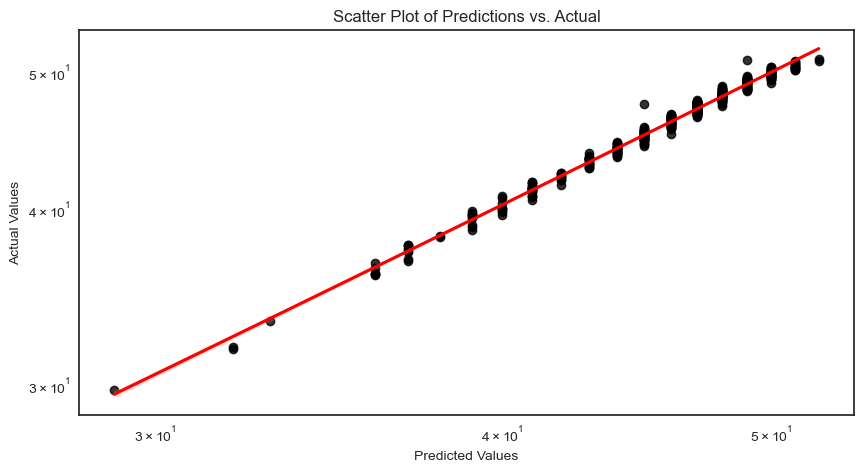

In [1456]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.regplot(
    x=y_val.detach().flatten().numpy(),
    y=bestModel(X_val).detach().flatten().numpy(),
    scatter_kws={"color": "black"},
    line_kws={"color": "red"})
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Scatter Plot of Predictions vs. Actual')
plt.show()